<a href="https://colab.research.google.com/github/nickystark/TerroristDetection/blob/main/TerroristDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [4]:
!pip install -q pytorch-lightning

In [5]:
import os
import torch
import torchmetrics
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

#Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
output_folder = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/augmented_images-Ter'  # Replace with your desired folder path
if not os.path.exists(output_folder):
  os.makedirs(output_folder, exist_ok=True)

# **Path Images**

In [8]:
#train path
main_path = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection'
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
valid_dir = os.path.join(main_path, 'valid')

#valid path
valid_dir = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/valid'
valid_ter = os.path.join(valid_dir, 'Terrorist')
valid_no_ter = os.path.join(valid_dir, 'NoTerrorist')
valid_ter_mult = os.path.join(valid_dir, 'Terrorist_multiple')
valid_no_ter_mult = os.path.join(valid_dir, 'NoTerrorist_multiple')

#test path
test_dir = '/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/test'
test_ter = os.path.join(test_dir, 'Terrorist')
test_no_ter = os.path.join(test_dir, 'NoTerrorist')
test_ter_mult = os.path.join(test_dir, 'Terrorist_multiple')
test_no_ter_mult = os.path.join(test_dir, 'NoTerrorist_multiple')

#Train

In [9]:
#Terrorist Folders
train_ter = os.path.join(train_dir, 'Terrorist')
train_ter_mult = os.path.join(train_dir, 'Terrorist_multiple')
#Not Terrorist Folders
train_no_ter = os.path.join(train_dir, 'NoTerrorist')
train_no_ter1 = os.path.join(train_dir, 'NoTerrorist Terrorist')
train_no_ter_mult = os.path.join(train_dir, 'NoTerrorist Terrorist_multiple')
train_no_ter_mult1 = os.path.join(train_dir, 'NoTerrorist_multiple')
train_no_ter_mult2 = os.path.join(train_dir, 'NoTerrorist_multiple Terrorist')
train_no_ter_mult3 = os.path.join(train_dir, 'NoTerrorist_multiple Terrorist_multiple')

# Dataframe

In [10]:
train_data = []
train_labels = []

valid_data = []
valid_labels = []

test_data = []
test_labels = []

def create_dataframe(path, data, labels):
  last_word = path.split('/')[-1]

  if 'No' in last_word:
    label = 0 #not terrorist
  else:
    label = 1 #terrorist

  for filepath in os.listdir(path):
    completeFilePath = os.path.join(path, filepath)
    data.append(completeFilePath)
    labels.append(label)

#create_dataframe TRAIN
create_dataframe(train_no_ter, train_data, train_labels)
create_dataframe(train_ter, train_data, train_labels)
create_dataframe(train_no_ter1, train_data, train_labels)
create_dataframe(train_no_ter_mult, train_data, train_labels)
create_dataframe(train_no_ter_mult1, train_data, train_labels)
create_dataframe(train_no_ter_mult2, train_data, train_labels)
create_dataframe(train_no_ter_mult3, train_data, train_labels)
create_dataframe(train_ter_mult, train_data, train_labels)
#create_dataframe VALID
create_dataframe(valid_no_ter, valid_data, valid_labels)
create_dataframe(valid_ter, valid_data, valid_labels)
create_dataframe(valid_ter_mult, valid_data, valid_labels)
create_dataframe(valid_no_ter_mult, valid_data, valid_labels)
#create_dataframe TEST
create_dataframe(test_no_ter, test_data, test_labels)
create_dataframe(test_ter, test_data, test_labels)
create_dataframe(test_no_ter_mult, test_data, test_labels)
create_dataframe(test_ter_mult, test_data, test_labels)


In [11]:
#Create Train Dataframe (namepath, label)
train_df = pd.DataFrame({'filename': train_data, 'label': train_labels})
train_df

,filename,label
0,/content/drive/MyDrive/TerroristDetection/Terr...,0
1,/content/drive/MyDrive/TerroristDetection/Terr...,0
2,/content/drive/MyDrive/TerroristDetection/Terr...,0
3,/content/drive/MyDrive/TerroristDetection/Terr...,0
4,/content/drive/MyDrive/TerroristDetection/Terr...,0
...,...,...
2887,/content/drive/MyDrive/TerroristDetection/Terr...,1
2888,/content/drive/MyDrive/TerroristDetection/Terr...,1
2889,/content/drive/MyDrive/TerroristDetection/Terr...,1
2890,/content/drive/MyDrive/TerroristDetection/Terr...,1


Augmented images

In [12]:
#Tranformations for augmented images
tr_augmented1 = transforms.Compose([
  transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally
  transforms.RandomRotation(20),    # Randomly rotates the image up to 20 degrees
  transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # Randomly crops the image
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2), # Randomly adjusts the color
])

tr_augmented2 = transforms.Compose([
  transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally
  transforms.RandomRotation(51),    # Randomly rotates the image up to 20 degrees
  transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # Randomly crops the image
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2), # Randomly adjusts the color
  transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
])

# Create a separate list to store augmented image data
augmented_data = []

for round in range(3):
  for index, row in train_df.iterrows():
      # Check if the image should be augmented (e.g., if label is of a specific class)
      if row['label'] == 1:
        imagepath = row['filename']
        print(imagepath)
        if os.path.exists(imagepath):
          image = Image.open(imagepath).convert('RGB')
          image_augmented1 = tr_augmented1(image)
          image_augmented2 = tr_augmented2(image)
          # Generate a unique filename for the augmented image
          filename1 = f"augmented1_{index}_{round}.jpg"  # name of the file
          filename2 = f"augmented2_{index}_{round}.jpg"  # name of the file

          # Save the augmented image to the output folder
          image_augmented1.save(os.path.join(output_folder, filename1))
          image_augmented2.save(os.path.join(output_folder, filename2))

          # Append the augmented data to the list
          filepath1 = (output_folder, filename1)
          augmented_data.append({'filename': "/".join(filepath1), 'label': row['label']})
          filepath2 = (output_folder, filename2)
          augmented_data.append({'filename': "/".join(filepath2), 'label': row['label']})

# Add the augmented data to the DataFrame outside the loop
train_df = pd.concat([train_df, pd.DataFrame(augmented_data)], ignore_index=True)
train_df

/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/Terrorist/3640_png.rf.ae1dcb5bcec9a056558ce778ca28d2a8.jpg
/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/Terrorist/00152_png.rf.6f29ee4bfe9b250341718dbc25469eac.jpg
/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/Terrorist/image_2486_jpg.rf.2a0abb9ae7a3ad59cfd037b0911c100a.jpg
/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/Terrorist/3301_png.rf.c82ed1d75d9650fc4436f2e106c5fb3e.jpg
/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/Terrorist_multiple/3910_png.rf.8d312f857ab7d10b97095d764ab22138.jpg
/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/Terrorist_multiple/1-Al-Shabaab_jpg.rf.32bd131cb5ed52df6ff18f9240ed0103.jpg
/content/drive/MyDrive/TerroristDetection/Terrorist And No Terrorist Detection/train/Terrorist_multiple

,filename,label
0,/content/drive/MyDrive/TerroristDetection/Terr...,0
1,/content/drive/MyDrive/TerroristDetection/Terr...,0
2,/content/drive/MyDrive/TerroristDetection/Terr...,0
3,/content/drive/MyDrive/TerroristDetection/Terr...,0
4,/content/drive/MyDrive/TerroristDetection/Terr...,0
...,...,...
3493,/content/drive/MyDrive/TerroristDetection/Terr...,1
3494,/content/drive/MyDrive/TerroristDetection/Terr...,1
3495,/content/drive/MyDrive/TerroristDetection/Terr...,1
3496,/content/drive/MyDrive/TerroristDetection/Terr...,1


In [13]:

#valid_dataframe
valid_df = pd.DataFrame({'filename': valid_data, 'label': valid_labels})
valid_df

,filename,label
0,/content/drive/MyDrive/TerroristDetection/Terr...,0
1,/content/drive/MyDrive/TerroristDetection/Terr...,0
2,/content/drive/MyDrive/TerroristDetection/Terr...,0
3,/content/drive/MyDrive/TerroristDetection/Terr...,0
4,/content/drive/MyDrive/TerroristDetection/Terr...,0
...,...,...
270,/content/drive/MyDrive/TerroristDetection/Terr...,0
271,/content/drive/MyDrive/TerroristDetection/Terr...,0
272,/content/drive/MyDrive/TerroristDetection/Terr...,0
273,/content/drive/MyDrive/TerroristDetection/Terr...,0


In [14]:
#test_data
test_df = pd.DataFrame({'filename': test_data, 'label': test_labels})
test_df

,filename,label
0,/content/drive/MyDrive/TerroristDetection/Terr...,0
1,/content/drive/MyDrive/TerroristDetection/Terr...,0
2,/content/drive/MyDrive/TerroristDetection/Terr...,0
3,/content/drive/MyDrive/TerroristDetection/Terr...,0
4,/content/drive/MyDrive/TerroristDetection/Terr...,0
...,...,...
137,/content/drive/MyDrive/TerroristDetection/Terr...,1
138,/content/drive/MyDrive/TerroristDetection/Terr...,1
139,/content/drive/MyDrive/TerroristDetection/Terr...,1
140,/content/drive/MyDrive/TerroristDetection/Terr...,1


In [15]:
#random.shuffle(train_df)
# Mischia il DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

<Axes: title={'center': 'label'}, ylabel='Frequency'>

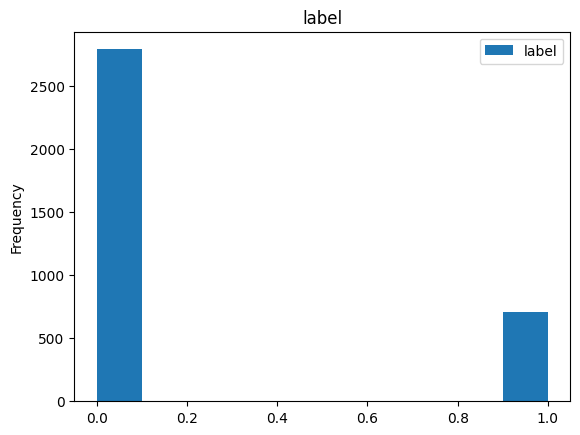

In [16]:
train_df.plot(kind='hist', title = 'label')


Valid Plot

<Axes: title={'center': 'label'}, ylabel='Frequency'>

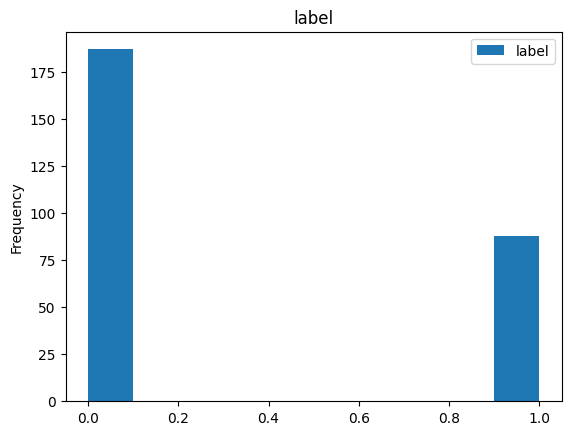

In [17]:
valid_df.plot(kind='hist', title = 'label')

Test Plot

<Axes: title={'center': 'label'}, ylabel='Frequency'>

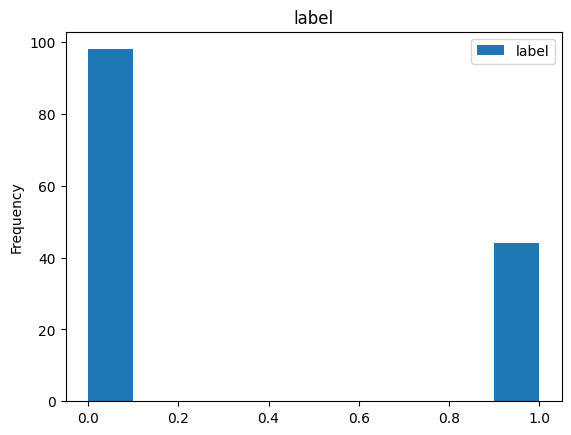

In [18]:
test_df.plot(kind='hist', title = 'label')


# Dataset

In [19]:
class terrorismDetectionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.data = []
        for index, row in df.iterrows():
          imagepath = row['filename']
          label = row['label']
          # Check if imagepath is bytes-like (augmented image)
          if isinstance(imagepath, bytes):
            # Load from bytes if it's an augmented image
            image = Image.open(BytesIO(imagepath)).convert('RGB')
          else:
            # Load from file path if it's a regular image
            image = Image.open(imagepath).convert('RGB')
          tr = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
        ])
          imageTransorfm = tr(image)
          item = {'input': imageTransorfm, 'label': label, 'realImage' : image}
          self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = self.data[idx]['input']
        label = self.data[idx]['label']
        imagepath = self.df.iloc[idx]['filename'] # Get imagepath from the DataFrame
        # Check if imagepath is bytes-like (augmented image)
        if isinstance(imagepath, bytes):
            # Load from bytes if it's an augmented image
            image = Image.open(BytesIO(imagepath)).convert('RGB')
        else:
            # Load from file path if it's a regular image
            image = Image.open(imagepath).convert('RGB')
        tr = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        imageTransorfm = tr(image)
        item = {'input': input, 'label': label, 'realImage' : image}
        return item

In [ ]:
train_dataset = terrorismDetectionDataset(train_df)


In [ ]:
train_dataset.__len__()

In [ ]:
train_dataset.__getitem__(10).get('input').size()

In [ ]:
train_dataset.__getitem__(10).get('input')


In [ ]:
real_image = train_dataset.__getitem__(10).get('realImage')
real_image

#Data Module

In [ ]:
class terrorismDetectionDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_df,
                 valid_df,
                 test_df,
                 batch_size : int = 2,
    ):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = terrorismDetectionDataset(self.train_df)
            self.valid_dataset = terrorismDetectionDataset(self.valid_df)
        if stage == 'test':
            self.test_dataset = terrorismDetectionDataset(self.test_df)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, collate_fn=self.prepare_batch)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, collate_fn=self.prepare_batch)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, collate_fn=self.prepare_batch)

    def prepare_batch(self, batch):
      prepared_batch = {}
      inputs = [item['input'] for item in batch]
      labels = [item['label'] for item in batch]
      prepared_batch['input'] = torch.stack(inputs)
      prepared_batch['label'] = torch.tensor(labels)
      return prepared_batch

In [ ]:
prova_dataModule = terrorismDetectionDataModule(train_df, valid_df, test_df)

#Device

In [ ]:
! nvidia-smi
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#Model

In [ ]:
class myModel(pl.LightningModule):
    def __init__(self):
        super(myModel, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=1)
        self.convolution2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1)
        self.convolution4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(in_features=32 * 53 * 53, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()
        self.accuracy = torchmetrics.Accuracy(task="binary")
        self.loss = nn.BCELoss()
        self.train_loss = []
        self.val_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.test_accuracy = []
        self.train_loss_for_plot = []
        self.val_loss_for_plot = []
        self.test_loss_for_plot = []
        self.train_accuracy_for_plot = []
        self.val_accuracy_for_plot = []
        self.test_accuracy_for_plot = []

    def forward(self, x):
        x = self.convolution1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.convolution2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        loss = self.loss(outputs, labels.unsqueeze(1).float())
        accuracy = self.accuracy(outputs, labels.unsqueeze(1).float())

        self.log('train_loss', loss)
        self.log('train_accuracy', accuracy)
        self.train_loss.append(loss.item())
        self.train_accuracy.append(accuracy.item())
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        loss = self.loss(outputs, labels.unsqueeze(1).float())
        accuracy = self.accuracy(outputs, labels.unsqueeze(1).float())

        self.log('val_loss', loss)
        self.log('val_accuracy', accuracy)
        self.val_loss.append(loss.item())
        self.val_accuracy.append(accuracy.item())
        return loss

    def test_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        loss = self.loss(outputs, labels.unsqueeze(1).float())
        accuracy = self.accuracy(outputs, labels.unsqueeze(1).float())

        self.log('test_loss', loss)
        self.log('test_accuracy', accuracy)
        return loss

    def on_train_epoch_end(self):
        avg_train_loss = sum(self.train_loss) / len(self.train_loss) if self.train_loss else 0
        avg_train_accuracy = sum(self.train_accuracy) / len(self.train_accuracy) if self.train_accuracy else 0
        print(f'Epoch {self.current_epoch} Train\n'
                f'- Train Loss: {avg_train_loss:.4f}'
                f'- Train Accuracy: {avg_train_accuracy:.4f}'
                )
        self.train_loss_for_plot.append(avg_train_loss)
        self.train_loss = []
        self.train_accuracy_for_plot.append(avg_train_accuracy)
        self.train_accuracy = []

    def on_validation_epoch_end(self):
        avg_val_loss = sum(self.val_loss) / len(self.val_loss) if self.val_loss else 0
        avg_val_accuracy = sum(self.val_accuracy) / len(self.val_accuracy) if self.val_accuracy else 0
        print(f'Epoch {self.current_epoch} Validation\n'
                f'- Validation Loss: {avg_val_loss:.4f}'
                f'- Validation Accuracy: {avg_val_accuracy:.4f}'
                )
        self.val_loss_for_plot.append(avg_val_loss)
        self.val_loss = []
        self.val_accuracy_for_plot.append(avg_val_accuracy)
        self.val_accuracy = []

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay=0.001)
        return optimizer

#Setup

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
trainer = pl.Trainer(max_epochs = 50)#, callbacks=[early_stopping])

In [ ]:
myDataModule = terrorismDetectionDataModule(train_df, valid_df, test_df, {'batch_size' : 1})
my_model = myModel()

In [ ]:
trainer.fit(my_model, myDataModule)